# Generic dfs processing
Tools and methods that applies to any type of dfs files. 

* mikeio.read()
* mikeio.generic: methods that read any dfs file and outputs a new dfs file of the same type
   - concat: Concatenates files along the time axis  
   - scale: Apply scaling to any dfs file
   - sum: Sum two dfs files 
   - diff: Calculate difference between two dfs files
   - extract: Extract timesteps and/or items to a new dfs file
   - time-avg: Create a temporally averaged dfs file
   - quantile: Create temporal quantiles of dfs file


In [1]:
import matplotlib.pyplot as plt
import mikeio
import mikeio.generic

## Concatenation

Take a look at these two files with overlapping timesteps.

In [2]:
t1 = mikeio.read("../tests/testdata/tide1.dfs1")
t1

<mikeio.Dataset>
Dimensions: (time:97, x:10)
Time: 2019-01-01 00:00:00 - 2019-01-03 00:00:00 (97 records)
Items:
  0:  Level <Water Level> (meter)

In [3]:
t2 = mikeio.read("../tests/testdata/tide2.dfs1")
t2

<mikeio.Dataset>
Dimensions: (time:97, x:10)
Time: 2019-01-02 00:00:00 - 2019-01-04 00:00:00 (97 records)
Items:
  0:  Level <Water Level> (meter)

Plot one of the points along the line.

c:\users\jem\source\mikeio\mikeio\dataset.py:379: FutureWarning: property data is deprecated, use to_numpy() instead
  warnings.warn(
c:\users\jem\source\mikeio\mikeio\dataset.py:379: FutureWarning: property data is deprecated, use to_numpy() instead
  warnings.warn(


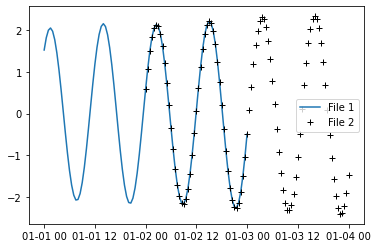

In [4]:
plt.plot(t1.time,t1.data[0][:,1], label="File 1")
plt.plot(t2.time,t2.data[0][:,1],'k+', label="File 2")
plt.legend()

In [5]:
mikeio.generic.concat(infilenames=["../tests/testdata/tide1.dfs1",
                                   "../tests/testdata/tide2.dfs1"],
                     outfilename="concat.dfs1")

c:\users\jem\source\mikeio\mikeio\dataset.py:379: FutureWarning: property data is deprecated, use to_numpy() instead
  warnings.warn(


<mikeio.Dataset>
Dimensions: (time:145, x:10)
Time: 2019-01-01 00:00:00 - 2019-01-04 00:00:00 (145 records)
Items:
  0:  Level <Water Level> (meter)

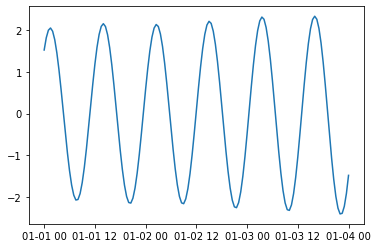

In [6]:
c = mikeio.read("concat.dfs1")
plt.plot(c.time,c.data[0][:,1])
c

## Difference between two files

Take difference between two dfs files with same structure - e.g. to see the difference in result between two calibration runs

In [7]:
fn1 = "../tests/testdata/oresundHD_run1.dfsu"
fn2 = "../tests/testdata/oresundHD_run2.dfsu"
fn_diff = "oresundHD_difference.dfsu"
mikeio.generic.diff(fn1, fn2, fn_diff)

100%|██████████| 5/5 [00:00<00:00, 4516.80it/s]


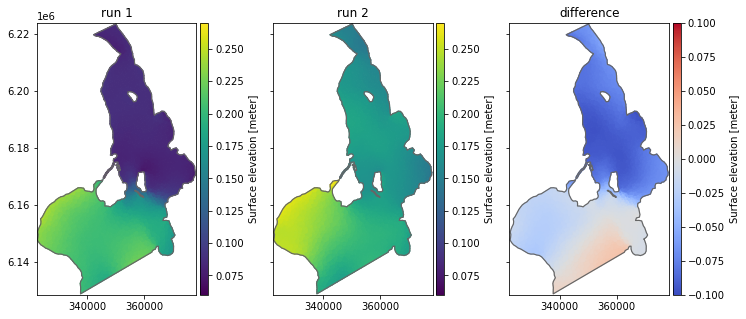

In [8]:
_, ax = plt.subplots(1,3, sharey=True, figsize=(12,5))
da = mikeio.read(fn1, time=-1)[0]
da.plot(vmin=0.06, vmax=0.27, ax=ax[0], title='run 1')
da = mikeio.read(fn2, time=-1)[0]
da.plot(vmin=0.06, vmax=0.27, ax=ax[1], title='run 2')
da = mikeio.read(fn_diff, time=-1)[0]
da.plot(vmin=-0.1, vmax=0.1, cmap='coolwarm', ax=ax[2], title='difference');

## Extract time steps or items

The extract() method can extract a part of a file:

* **time slice** by specifying *start* and/or *end*
* specific **items**

In [9]:
infile = "../tests/testdata/tide1.dfs1"
mikeio.generic.extract(infile, "extracted.dfs1", start='2019-01-02')

In [10]:
e = mikeio.read("extracted.dfs1")
e

<mikeio.Dataset>
Dimensions: (time:49, x:10)
Time: 2019-01-02 00:00:00 - 2019-01-03 00:00:00 (49 records)
Items:
  0:  Level <Water Level> (meter)

In [11]:
infile = "../tests/testdata/oresund_vertical_slice.dfsu"
mikeio.generic.extract(infile, "extracted.dfsu", items='Salinity', end=-2)

In [12]:
e = mikeio.read("extracted.dfsu")
e

<mikeio.Dataset>
Geometry: DfsuVerticalProfileSigmaZ (4 sigma-layers, 5 z-layers)
Dimensions: (time:2, element:441)
Time: 1997-09-15 21:00:00 - 1997-09-16 00:00:00 (2 records)
Items:
  0:  Salinity <Salinity> (PSU)

## Scaling

Adding a constant e.g to adjust datum

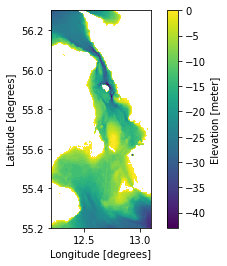

In [13]:
ds = mikeio.read("../tests/testdata/gebco_sound.dfs2")
ds.Elevation[0].plot();

In [14]:
ds['Elevation'][0,104,131].to_numpy()

array(-1.)

This is the processing step.

In [15]:
mikeio.generic.scale("../tests/testdata/gebco_sound.dfs2", 
                     "gebco_sound_local_datum.dfs2",
                     offset=-2.1
                     )

<AxesSubplot:xlabel='Longitude [degrees]', ylabel='Latitude [degrees]'>

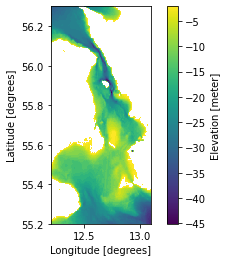

In [16]:
ds2 = mikeio.read("gebco_sound_local_datum.dfs2")
ds2['Elevation'][0].plot()

In [17]:
ds2['Elevation'][0,104,131].to_numpy()

array(-3.0999999)

### Spatially varying correction

In [18]:
import numpy as np
factor = np.ones_like(ds['Elevation'][0].to_numpy())
factor.shape

(264, 216)

Add some spatially varying factors, exaggerated values for educational purpose.

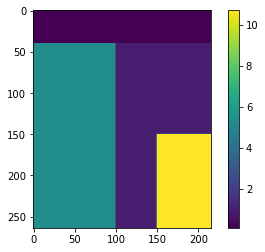

In [19]:
factor[:,0:100] = 5.3
factor[0:40,] = 0.1
factor[150:,150:] = 10.7
plt.imshow(factor)
plt.colorbar();

The 2d array must first be flipped upside down and then converted to a 1d vector using [numpy.ndarray.flatten](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) to match how data is stored in dfs files.

In [20]:
factor_ud = np.flipud(factor)
factor_vec  = factor_ud.flatten()
mikeio.generic.scale("../tests/testdata/gebco_sound.dfs2", 
                     "gebco_sound_spatial.dfs2",
                     factor=factor_vec
                     )

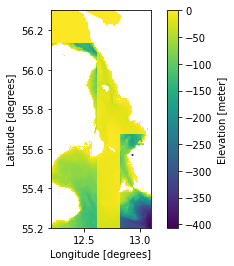

In [21]:
ds3 = mikeio.read("gebco_sound_spatial.dfs2")
ds3.Elevation[0].plot();

## Time average

In [22]:
fn = "../tests/testdata/NorthSea_HD_and_windspeed.dfsu"
fn_avg = "Avg_NorthSea_HD_and_windspeed.dfsu"
mikeio.generic.avg_time(fn, fn_avg)

In [23]:
ds = mikeio.read(fn)
ds.mean(axis=0).describe()   # alternative way of getting the time average

,Surface elevation,Wind speed
count,958.000000,958.000000
mean,0.449857,12.772705
std,0.178127,2.367667
min,0.114355,6.498364
25%,0.373691,11.199439
50%,0.431747,12.984060
75%,0.479224,14.658077
max,1.202888,16.677953


In [24]:
ds_avg = mikeio.read(fn_avg)
ds_avg.describe()

,Surface elevation,Wind speed
count,958.000000,958.000000
mean,0.449857,12.772705
std,0.178127,2.367667
min,0.114355,6.498364
25%,0.373691,11.199439
50%,0.431747,12.984060
75%,0.479224,14.658077
max,1.202888,16.677954


## Quantile

Example that calculates the 25%, 50% and 75% percentile for all items in a dfsu file.

In [25]:
fn = "../tests/testdata/NorthSea_HD_and_windspeed.dfsu"
fn_q = "Q_NorthSea_HD_and_windspeed.dfsu"
mikeio.generic.quantile(fn, fn_q, q=[0.25,0.5,0.75])

In [26]:
dfs = mikeio.Dfsu(fn_q)
ds = dfs.read()
ds

<mikeio.Dataset>
Geometry: Dfsu2D
Dimensions: (time:1, element:958)
Time: 2017-10-27 00:00:00 (time-invariant)
Items:
  0:  Quantile 0.25, Surface elevation <Surface Elevation> (meter)
  1:  Quantile 0.5, Surface elevation <Surface Elevation> (meter)
  2:  Quantile 0.75, Surface elevation <Surface Elevation> (meter)
  3:  Quantile 0.25, Wind speed <Wind speed> (meter per sec)
  4:  Quantile 0.5, Wind speed <Wind speed> (meter per sec)
  5:  Quantile 0.75, Wind speed <Wind speed> (meter per sec)

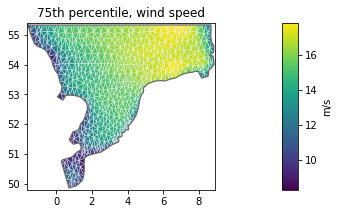

In [27]:
dat = ds["Quantile 0.75, Wind speed"][0,:]
dfs.plot(dat, title="75th percentile, wind speed", label="m/s");

## Clean up

In [28]:
import os
os.remove("concat.dfs1")
os.remove("oresundHD_difference.dfsu")
os.remove("extracted.dfs1")
os.remove("extracted.dfsu")
os.remove("gebco_sound_local_datum.dfs2")
os.remove("gebco_sound_spatial.dfs2")
os.remove("Avg_NorthSea_HD_and_windspeed.dfsu")
os.remove(fn_q)